# Algorithmic Multi-Greek Hedging using Python
- [Delta hedging a single option](##Delta-hedging-a-single-option)
- [Delta hedging performance](##Delta-hedging-performance)
- [Delta-vega hedging a single option](##Delta-vega-hedging-a-single-option)
- [Delta-vega hedging performance](##Delta-vega-hedging-performance)

This report consists of four sections as per the table of contents above. First an algorithm is developed for delta hedging a single option trough to time until maturity (TTM). After that its performance is tested on all options in the isx2010C.xls with a complete history. Finally the procedure is repeated for delta-vega hedging.

The data used is from an Excel file; isx2010C.xls, which contains real options data from 2010. The undelying is the SP100 index (futures?). Risk free interest rate is reported for each day in basis points. Each worksheet represents a different call options chain with a particular expiration date. Each row contains daily information on call values for different strikes as well as the underlying.

For the readabilitys sake some of the functions (bisection root finding algorithm and xls parsing function) used here have been put in the utils.py file.

The hypothetical scenario is going long a certain amount of contracts (100) and then dynamically hedging this position until expiry. This is almost identical to going short the contracts instead because in these scenarios we would get the needed hedge by just flipping the sign of our hedge positions.

In [17]:
import pandas as pd
import numpy as np
import scipy.stats as s
from datetime import datetime
from pyfinance.options import BSM
import warnings
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from utils import bisection, parse_xls

We start by parsing the xls file and reading it into a list of pandas dataframes. One dataframe for each sheet. There is alot of data-engineering and error handling in this step and the code and documentation in utils.py provides more explanation. 

Sometimes the values were 1000 times to large and atleast once about 100 to little in particular a Call option at 16.12.2010 with Value 1.35 and S = 559.4, K= 460, TTM= 2, no arbitrage would suggest that the value is atleast S-K = 99.4. Most of these can be handled by some logic but not all. This unfortunately skews the results.

In [18]:
dfs = parse_xls('isx2010C.xls')

## Delta hedging a single option

In order for us to hedge the open position we need to know our exposure; our position greeks. I will not introduce the background mathematics here, Paul Wilmott introduces quantitative finance is an excelent resource for that.

We need to know our greeks ($\Delta$ for delta hedging, and $\Delta$ and $\nu$ for delta-vega hedging) but only price is provided. The pricing depends on the implied volatility (IV) which we can calculate based on the price. We can then calculate the greeks with the know IV and other parameters.

It turns out that calculating IV from known price is not as straight forward as one would think. Here the pyfinance implementation (Brenner & Subrahmanyan, A Simple Formula to Compute the Implied Standard Deviation, 1988.) is used as help with its ready made implementations for the most common tasks. However the pyfinance implied volatility calculation often fails on real world data. 

When the ´Brenner & Subrahmanyan´ method fails we resort to the bisection method (utils.py) which sometimes also fails. The most common reason for this is that deep in the money calls often have very low IV < 0.01 and even with IV set lower than that does not result in the observed price. If the prices in the sheets represents asks then this would mean that there is an arbitrage opportunity and ofcourse then pricing fails. The lower prices than the intrinsic value is indeed strange but would be logical if the prices are mids or bids, since these far from the money options are often not traded much. If the bisection method failes we use IV = .0001 if the resulting price error is < 100% to calculate the greeks. This most often gives a price that is less than 1% away from the real one.


The `delta_vega_from_value` function below implements this logic.

In [19]:
def delta_vega_from_value(asset_spot,strike,TTM,V,r,date):
    """
    Returns the delta and vega for the Call, with the specified parameters.
    Calculated with the implied volatility.
    First using the Newtons method provided by the pyfinance package, then resorting to the bisection method if that fails.
    Finally using IV = .0001 if the error is < 100 % if also the bisection method fails.
    If the error is over 100% with this then the function fails and returns nan,nan.
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        Iv = BSM(S0 = asset_spot, K = strike,T = TTM/365.0,r=r,sigma=0.5,kind='call').implied_vol(V)
        C = BSM(S0 = asset_spot, K = strike,T = TTM/365.0,r=r,sigma=Iv,kind='call')

    if abs(C.value()-V) <= 0.1 and not np.isnan(C.value()):
        return C.delta(), C.vega()
    else:
        #print(f'Resorting to bisection method for implied volatility for Call option at {date} with Value {V} and S = {asset_spot}, K= {strike} !')
        #try bisection method
        try:
            Iv = bisection(lambda sigma: V - BSM(S0 = asset_spot, K = strike, T = TTM/365.0, r=r, sigma=sigma, kind='call').value(), 0.00001, 0.999, 0.0001, 150)
            C = BSM(S0 = asset_spot, K = strike,T = TTM/365.0,r=r,sigma=Iv,kind='call')
            #print(C.summary())
            if abs(C.value()-V) <= 0.1 and not np.isnan(C.value()):
                return C.delta(), C.vega()
        except AssertionError:
            print(f"Implied volatility calculation failed with bisection method for Call option at {date} with Value {V} and S = {asset_spot}, K= {strike}, TTM= {TTM} !'")
            # Sometimes there can be pricing errors so that the price would offer arbitrage, can be timing is off or just a small time but leads to pricing failing
            # So we handle that with this workaround
            C = BSM(S0 = asset_spot, K = strike, T = TTM/365.0, r=r, sigma=.0001, kind='call')
            percent_error = (abs(C.value()-V)/V)*100
            if percent_error < 100:
                print(f"Value for option with IV = .0001 -> {C.value()}, error: {percent_error} %")
                return C.delta(), C.vega()
            

            
        
    print(f'Failed to compute implied volatility for Call option at {date} with Value {V} and S = {asset_spot}, K= {strike}, TTM= {TTM} !')
    return np.nan, np.nan

    
    

The `simple_delta_hedge` function implements dynamic delta hedging for a Call with a given strike. The rehedging is done based on the specified `freq` parameter holding an opposite delta amount, $\Delta = \frac{dC^{BS}}{dS}$, of the underlying as a hedge.

In [20]:
def simple_delta_hedge(df,strike,freq: int, multiplier=100):

    """Expects df index to start at 0"""

    df = df[['TTM',strike,'r','SP100','date']]
    days = df.shape[0]
    As = [0] # the difference 𝐴 between the change in the value of the option and the change in the value of the replicating portfolio
    dOPs = [0]

    TTM, V, r, SP100, date = df.loc[0,:]
    dC,_ = delta_vega_from_value(asset_spot=SP100,strike=strike,TTM=TTM,V=V,r=r,date=date)
    OP = V*multiplier # Our open position 
    hedge = round(-multiplier*dC) # the amount of contracts held at time t
    adjustment = [hedge] # the transactions in the undelying

    # simulate the hedging transactions and compute hedging "loss" A daily
    for t in range(1,days):
        TTM, V_new, r, SP100_new, date = df.loc[t,:]
        dOP = (V_new-V)*multiplier
        dhedge = hedge*(SP100_new-SP100)
        A = dOP + dhedge # + because hedge is negative
        
        # rehedge according to strategy
        if t % freq == 0 :
            dC_new,_ = delta_vega_from_value(asset_spot=SP100_new,
                                            strike=strike,
                                            TTM=TTM,
                                            V=V_new,
                                            r=r,
                                            date=date) # calculate new delta for the day
            if not np.isnan(dC_new): # in the unlikely event that delta calculation fails do not change the hedge
                dC = dC_new
            new_hedge = round(-multiplier*dC) # new amount of underlying needed
            adjustment.append(new_hedge-hedge) # record trade
            hedge = new_hedge
        else:
            adjustment.append(0)
        
        #bookeeping
        dOPs.append(dOP)
        As.append(A)
        V = V_new
        SP100 = SP100_new
    
    return pd.DataFrame({'date': df['date'],'SP100': df['SP100'],'As':As, 'dOPs': dOPs, 'trades': adjustment})




The `simple_delta_hedge` function returns a data frame containing an array of values $A_t$. This is how we measure the hedging performance. We calculate:

$$
A_t = dOP_{t-1 \rightarrow t} - dRE_{t-1 \rightarrow t}
$$
where $dOP_{t-1 \rightarrow t}$ is the change in the options porfolio and $dRE_{t-1 \rightarrow t}$ is the change in the hedge between days $t$ and $t-1$ (rows in the sheet).

Our final error metric is $E = \frac{1}{n} \sum A^2$

In [21]:
hedge_sim_2_560 = simple_delta_hedge(df=dfs[2],strike=560,freq=1)
hedge_sim_2_560['As'] = hedge_sim_2_560['As']/100.0
hedge_sim_2_560['dOPs'] = hedge_sim_2_560['dOPs']/100.0

The output from a simulated delta hedge for 100 Call option contracts with K=560 and expiry 2010-12-17. The errors $A$ are here per quoted option value. Rehedging done every day and the trades in the underlying presented in the trades column.

In [22]:
hedge_sim_2_560

,date,SP100,As,dOPs,trades
0,2010-04-14,553.02,0.0000,0.00,-49
1,2010-04-15,553.87,-2.2165,-1.80,0
2,2010-04-16,544.68,3.9531,-0.55,4
3,2010-04-19,547.99,0.1105,1.60,-2
4,2010-04-20,551.08,-0.5023,0.95,-1
...,...,...,...,...,...
173,2010-12-13,557.81,-0.0160,0.20,-2
174,2010-12-14,558.64,-0.9986,-0.65,-1
175,2010-12-15,556.23,-0.1137,-1.15,13
176,2010-12-16,559.40,0.9890,1.94,-18


Next we plot the simulated 178 days of dynamic delta hedging.

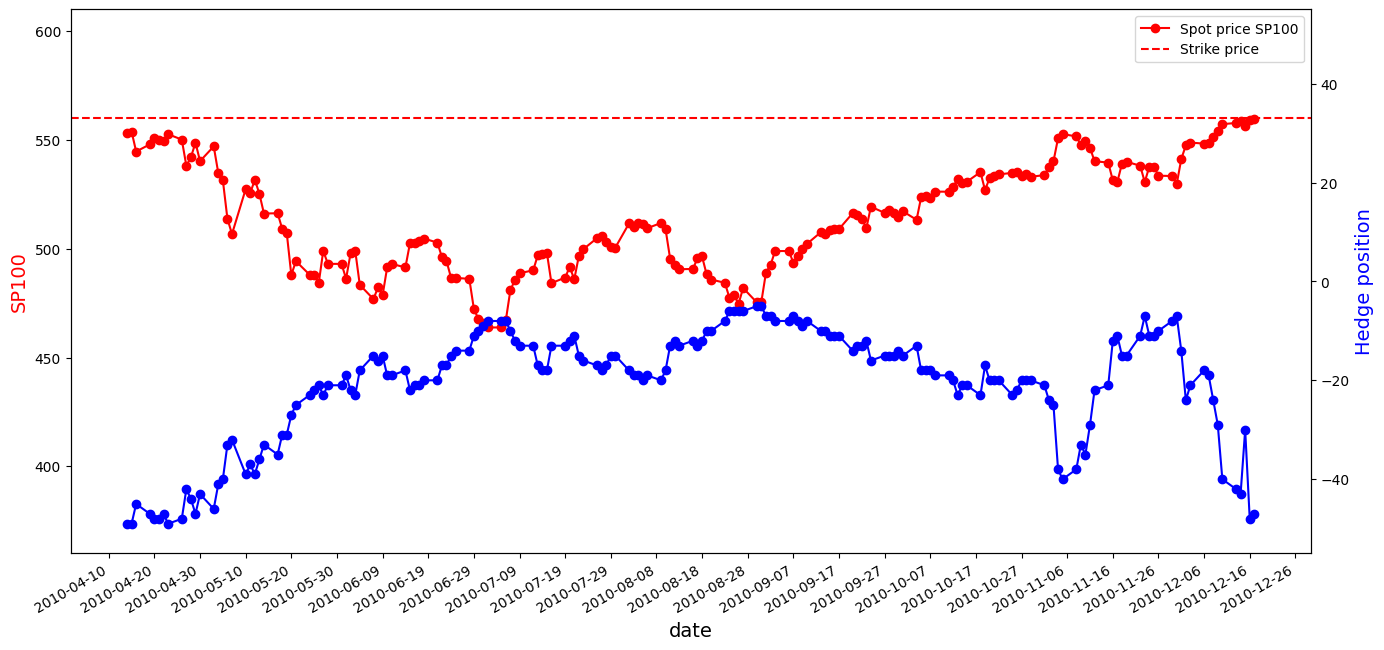

In [23]:
fig,ax = plt.subplots()

ax.plot(hedge_sim_2_560.date,
        hedge_sim_2_560.SP100,
        color="red", 
        marker="o",
        label='Spot price SP100')
ax.set_xlabel("date", fontsize = 14)
ax.set_ylabel("SP100",
              color="red",
              fontsize=14)
ax.axhline(y = 560, color = 'r', linestyle = 'dashed', label = 'Strike price') 
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax.legend(loc='upper right')
ax2.plot(hedge_sim_2_560.date, hedge_sim_2_560.trades.cumsum(),color="blue",marker="o")
ax2.set_ylabel("Hedge position",color="blue",fontsize=14)
ax.set_ylim((360, 610))
ax2.set_ylim((-55,55))
fig.set_size_inches(16., 8.)
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate()
plt.show()

We can notice that the closer to expiry we get the bigger the changes in the hedge.

## Delta hedging performance

Next we'll perform the above simulation for all strikes on all sheet with rehedging frequency 1,2,5 representing every day, every other trading day and every trading week.

In [24]:
def run_delta_hedge_on_sheets(data_frames, rehedge_frequency):
    errors = []
    for df in data_frames:
        for strike in df.columns[1:-3]: # the strike prices
            hedge_sim = simple_delta_hedge(df=df, strike=strike, freq=rehedge_frequency)
            hedge_sim['As'] = hedge_sim['As']/100.0
            hedge_sim['dOPs'] = hedge_sim['dOPs']/100.0
            E = ((hedge_sim['As'])**2).sum()/hedge_sim.shape[0]
            errors.append(E)
    return errors

In [25]:
%%capture
errors = [run_delta_hedge_on_sheets(dfs, f) for f in [1,2,5]];

The error distribution for for the different frequencies are presented below.

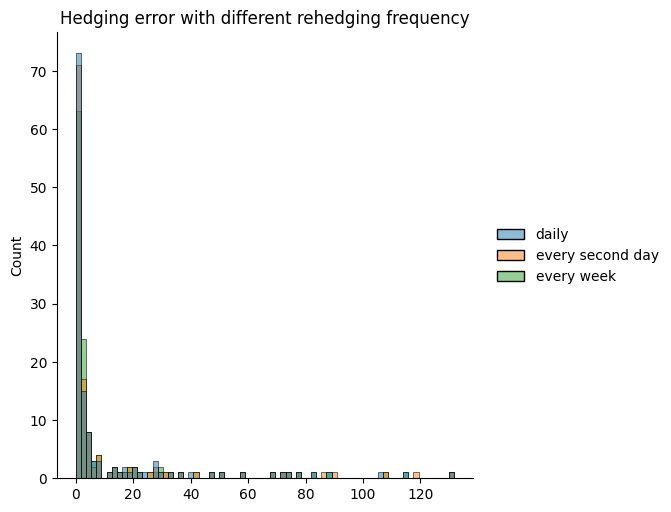

In [26]:
errors_df =pd.DataFrame(np.array(errors).T,columns=['daily', 'every second day', 'every week'])
sns.displot(errors_df)
plt.title('Hedging error with different rehedging frequency')
plt.show()

Noteworty is that the median performance for all frequencies is good but there is a really long right tail on the distribution. Some of these E's are probably an effect of the errors in the market data. One can also see that hedging more often provides slightly lower errors.

In [27]:
errors_df.describe()

,daily,every second day,every week
count,132.000000,132.000000,132.000000
mean,11.815014,12.008365,12.139975
std,24.521212,24.782190,24.601114
min,0.026133,0.026726,0.034903
25%,0.830604,0.852304,0.883587
50%,1.451497,1.453085,1.875618
75%,7.105967,7.346792,7.498159
max,131.713201,131.802810,131.743382


No big differences between the frequencies.

## Delta-vega hedging a single option

In this section we'll follow the same steps as above but now with delta-vega hedging.

What makes this abit more challenging is the data-engineering part where have to find a replicating option with a longer TTM to hedge our vega exposure.
This could in theory be any but here we use one with the same strike price but longer TTM.

Below is an example dataframe with the data needed for delta-vega hedging.

In [28]:
df1 = dfs[0][['TTM', 500,'date']]
df2 = dfs[1][['TTM', 500, 'SP100', 'r','date']]
df1.merge(df2,on='date',suffixes=('_1', '_2'),how='inner')

,TTM_1,500_1,date,TTM_2,500_2,SP100,r
0,66,21.50,2009-10-19,90,25.25,506.75,0.0007
1,65,21.30,2009-10-20,89,25.20,504.52,0.0007
2,64,18.60,2009-10-21,88,22.30,500.24,0.0007
3,63,20.90,2009-10-22,87,24.75,504.84,0.0007
4,62,18.40,2009-10-23,86,22.25,500.00,0.0007
...,...,...,...,...,...,...,...
60,6,29.70,2010-01-11,30,30.35,528.61,0.0006
61,5,25.55,2010-01-12,29,28.40,524.29,0.0006
62,4,28.60,2010-01-13,28,30.85,527.93,0.0006
63,3,30.80,2010-01-14,27,32.30,529.59,0.0006


Now our portfolio $P$ consists of three main components: a long option $C^{BS}$ with maturity $T$, an instantaneous $\alpha$ amount of the underlying stock with stochastic volatility, and an instantaneous amount $\eta$ of a replicating option $C^{rep} = C^{rep}(t,S_t,K,T_2,r,\sigma)$ on the same underlying SP100 index contract with the same strike price as the hedged option, but with a longer time until maturity $T_2 > T$.

We can calculate $\alpha$ and $\eta$ as:

$$
\alpha(\sigma) = \Delta^{BS}(\sigma) - \frac{\nu^{BS}(\sigma)}{\nu^{rep}(\sigma)} \Delta^{rep}(\sigma)
$$
$$
\eta(\sigma) =  \frac{\nu^{BS}(\sigma)}{\nu^{rep}(\sigma)}
$$

We can validate this by calculating the greeks for 100 contracts of  $C^{BS}(TTM=66,S_t=506.75,K=500,Value=21.50,r=0.0007)$

In [29]:
delta, vega = delta_vega_from_value(506.75, 500, 66, 21.50,0.0007,'19.10.2009')
delta_rep, vega_rep = delta_vega_from_value(506.75, 500, 90, 25.25, .0007,'19.10.2009')
portfolio_greeks = np.array([[delta], [vega]])*100
portfolio_greeks

array([[  57.78756733],
       [8432.339168  ]])

This gives $\Delta$= 57.79 and $\nu$ = 8432.34

In [30]:
alpha = delta*100 - (vega*100/vega_rep)*delta_rep
eta = (vega*100/vega_rep)
hedge_weights = np.array([[np.round(alpha)],[np.round(eta)]])
hedge_greeks = np.array([[1, delta_rep], [0,vega_rep]])
portfolio_greeks - hedge_greeks@hedge_weights, np.round(alpha),np.round(eta)

(array([[ 0.22281294],
        [36.25732748]]),
 9.0,
 85.0)

Calculating the hedge greeks and the respective $\alpha$ and $\eta$ and rounding (since we can only trade discrete amounts) gives us $\alpha$ = 9 and $\eta$  = 85.
Checking our resulting exposure; portfolio greeks - hedge_greeks*hedge_weights leaves us with $\Delta$= 0.22 and $\nu$ = 36.26.

In [31]:
def alpha_eta(dC, vega_C,delta_rep,vega_rep,multiplier):

    alpha = dC*multiplier
    eta = 0
    if vega_rep != 0:
        alpha = dC*multiplier - (vega_C*100/vega_rep)*delta_rep
        eta = (vega_C*100/vega_rep)

    return alpha, eta

So this method for finding the weights works, however for deep in the money options the $\eta$ can be 0 and this would result in dividing by zero. The workaround is to not hedge with the replicating option but just with the undelying, i.e resort to just delta hedging. Ofcourse one could if the option to be hedged had some vega search for another option but this is not done here because of the increased complexity.

In [32]:
def delta_vega_hedge(df,strike,freq: int, multiplier=100):
    """
    Expects df in column format [TTM_1, V_1, date, TTM_2, V_2, SP100,r]
    where 
    TTM_1: the time to maturity for the option to be hedged
    V_1: value of option to be hedged
    date: the date
    TTM_2: the time to maturity for the option to be used in hedging, same K but longer TTM.
    SP100: spot of the underlying
    r: the risk free interest rate
    """
    days = df.shape[0]
    As = [0] # the difference 𝐴 between the change in the value of the option and the change in the value of the replicating portfolio
    dOPs = [0]

    TTM_OP,	V_OP, date,	TTM_rep, V_rep,	SP100, r = df.loc[0,:]
    dC,vega_C = delta_vega_from_value(asset_spot=SP100,strike=strike,TTM=TTM_OP,V=V_OP,r=r,date=date)
    delta_rep, vega_rep = delta_vega_from_value(asset_spot=SP100,strike=strike,TTM=TTM_rep,V=V_rep,r=r,date=date)

    OP = V_OP*multiplier # Our open position 
    alpha, eta = alpha_eta(dC=dC, vega_C=vega_C,delta_rep=delta_rep,vega_rep=vega_rep,multiplier=multiplier) 
    #print(f"alpha: {alpha}, eta: {eta} ,dC: {dC}, vega_C {vega_C}, delta_rep: {delta_rep}, vega_rep {vega_rep}")
    hedge_SP100 = round(-alpha) # the amount of contracts held at time t as hedge
    hedge_C = round(-eta) # the amount of contracts held at time t as hedge

    adjustments_SP100 = [hedge_SP100] # the transactions in the undelying
    adjustments_C = [hedge_C]

    # simulate the hedging transactions and compute hedging "loss" A daily
    for t in range(1,days):
        TTM_OP,	V_OP_new, date,	TTM_rep, V_rep_new,	SP100_new, r = df.loc[t,:]
        dOP = (V_OP_new-V_OP)*multiplier
        dhedge_SP100 = hedge_SP100*(SP100_new-SP100)
        dhedge_C = hedge_C*(V_rep_new-V_rep)
        A = dOP + dhedge_SP100 + dhedge_C
        
        # rehedge according to strategy
        if t % freq == 0 :
            dC_new, vega_C_new = delta_vega_from_value(asset_spot=SP100_new, strike=strike, TTM=TTM_OP, V=V_OP_new ,r=r ,date=date)
            delta_rep_new, vega_rep_new = delta_vega_from_value(asset_spot=SP100_new, strike=strike, TTM=TTM_rep, V=V_rep_new, r=r, date=date) # calculate new delta vega for the day
            
            if not np.isnan(dC_new) and not np.isnan(delta_rep_new): # in the unlikely event that delta calculation fails do not change the hedge
                dC = dC_new
                vega_C = vega_C_new
                delta_rep = delta_rep_new
                vega_rep = vega_rep_new

            alpha, eta = alpha_eta(dC=dC, vega_C=vega_C,delta_rep=delta_rep,vega_rep=vega_rep,multiplier=multiplier) 
            #print(f"alpha: {alpha}, eta: {eta} ,dC: {dC}, vega_C {vega_C}, delta_rep: {delta_rep}, vega_rep {vega_rep}")
            new_hedge_SP100 = round(-alpha) # new amount of underlying needed
            adjustments_SP100.append(new_hedge_SP100-hedge_SP100) # record trade
            hedge_SP100 = new_hedge_SP100

            new_hedge_C = round(-eta)
            adjustments_C.append(new_hedge_C-hedge_C) # record trade
            hedge_C = new_hedge_C


        else:
            adjustments_SP100.append(0)
            adjustments_C.append(0)
        #bookeeping
        dOPs.append(dOP)
        As.append(A)
        V_OP = V_OP_new
        V_rep = V_rep_new
        SP100 = SP100_new
    
    return pd.DataFrame({'date': df['date'],'SP100': df['SP100'],'As':As, 'dOPs': dOPs, 'trades_SP100': adjustments_SP100, 'trades_C' : adjustments_C})



 ##### Next we'll compare dynamic delta and delta-vega hedging of 100 contracts of $C^{BS}(K=500)$ with rehedging every day

In [33]:
dv_hedge_sim = delta_vega_hedge(df1.merge(df2,on='date',suffixes=('_1', '_2'),how='inner'), 500, freq= 1, multiplier=100);
d_hedge_sim = simple_delta_hedge(dfs[0][dfs[0]['date'] >= pd.to_datetime('19.10.2009',dayfirst=True)].reset_index(),500,freq=1);

Implied volatility calculation failed with bisection method for Call option at 2010-01-15 00:00:00 with Value 24.0 and S = 524.11, K= 500, TTM= 2 !'
Value for option with IV = .0001 -> 24.111369861137177, error: 0.46404108807157246 %
Implied volatility calculation failed with bisection method for Call option at 2010-01-15 00:00:00 with Value 24.0 and S = 524.11, K= 500, TTM= 2 !'
Value for option with IV = .0001 -> 24.111369861137177, error: 0.46404108807157246 %


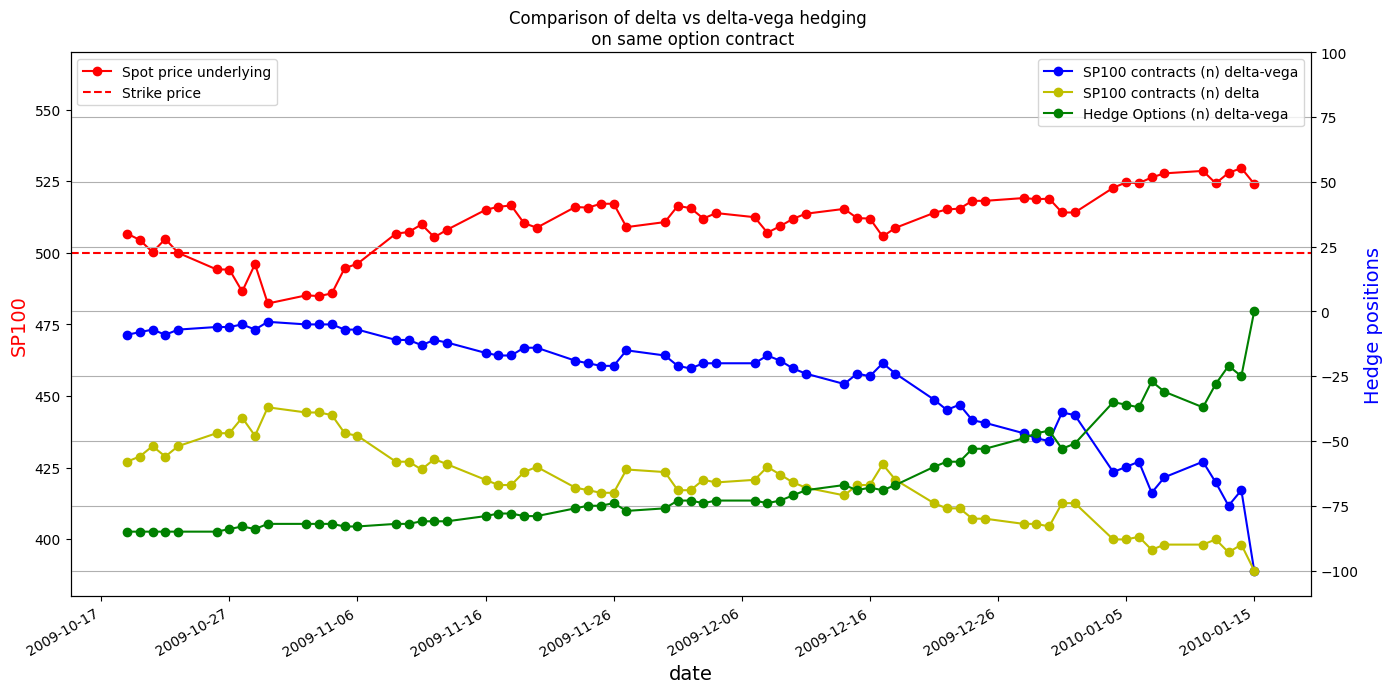

In [34]:
fig,ax = plt.subplots()

ax.plot(dv_hedge_sim['date'],
        dv_hedge_sim['SP100'],
        color="red", 
        marker="o",
        label='Spot price underlying')
ax.set_xlabel("date", fontsize = 14)
ax.set_ylabel("SP100",
              color="red",
              fontsize=14)
ax.axhline(y = 500, color = 'r', linestyle = 'dashed', label = 'Strike price') 
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(dv_hedge_sim['date'],
        dv_hedge_sim['trades_SP100'].cumsum(),
        color="blue",
        marker="o",
        label = 'SP100 contracts (n) delta-vega')
ax2.plot(d_hedge_sim['date'],
        d_hedge_sim['trades'].cumsum(),
        color="y",
        marker="o",
        label = 'SP100 contracts (n) delta')
ax2.set_ylabel("SP100 hedge position",color="blue",fontsize=14)
ax2.plot(dv_hedge_sim['date'],
        dv_hedge_sim['trades_C'].cumsum(),
        color="green",
        marker="o",
        label= 'Hedge Options (n) delta-vega')
ax2.set_ylabel("Hedge positions",fontsize=14)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.set_ylim((380, 570))
ax2.set_ylim((-110,100))
fig.set_size_inches(16., 8.)
ax2.grid()
plt.title('Comparison of delta vs delta-vega hedging \n on same option contract')
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate()
plt.show()

In [35]:
E_dv = ((dv_hedge_sim['As']/100)**2).sum()/dv_hedge_sim.shape[0] # Divide by 100 since 100 contracts were hedged to get error per contract
E_d = ((d_hedge_sim['As']/100)**2).sum()/d_hedge_sim.shape[0]
print(f"Error (E) for delta-vega hedging: {E_dv} for one option contract")
print(f"Error (E) for delta hedging: {E_d} for one option contract")

Error (E) for delta-vega hedging: 0.34597153338461206 for one option contract
Error (E) for delta hedging: 0.4516674215384643 for one option contract


In this good behaving example the delta-vega hedging produces better results.

## Delta-vega hedging performance

Next we'll perform the above simulation of delta-vega hedging for all strikes on all sheet with rehedging frequency 1,2,5. And present the results as in the previous manner.

In [36]:
def run_delta_vega_hedge_on_sheets(dfs, rehedge_frequency):
    errors = []
    for i,j in zip(range(0,len(dfs)-1), range(1,len(dfs))):
        strikes_to_hedge = [c for c in dfs[i].columns if c in dfs[j].columns][1:-3] # extract common strikes in sheets
        for strike in strikes_to_hedge:
                df1 = dfs[i][['TTM', strike,'date']]
                df2 = dfs[j][['TTM', strike, 'SP100', 'r','date']]
                df_merged = df1.merge(df2, on='date',suffixes=('_1', '_2'),how='inner')

                if not df_merged.empty: # only hedge if there is overlapping dates
                    dv_hedge_sim = delta_vega_hedge(df_merged, strike=strike, freq= rehedge_frequency, multiplier=100)
                    E = ((dv_hedge_sim['As']/100)**2).sum()/dv_hedge_sim.shape[0] # Divide by 100 since 100 contracts were hedged to get error per contract
                    errors.append(E)
                
    return errors

In [44]:
%%capture
errors_dv = [run_delta_vega_hedge_on_sheets(dfs, f) for f in [1,2,5]]

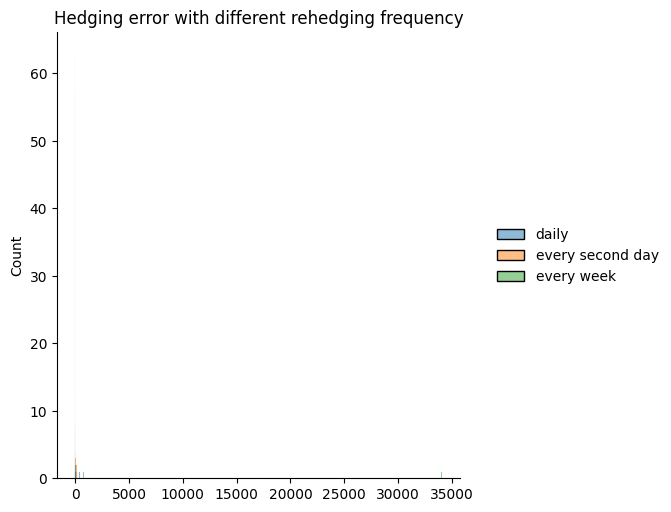

In [45]:
errors_dv_df =pd.DataFrame(np.array(errors_dv).T,columns=['daily', 'every second day', 'every week'])
sns.displot(errors_dv_df)
plt.title('Hedging error with different rehedging frequency')
plt.show()

There is for some reason extreme outliers when using delta-vega hedging compared to plain delta hedging. It seems that there is a single point skewing the results alot, it might me the Call option at 16.12.2010 with Value 1.35 and S = 559.4, K= 460, TTM= 2 already mentioned behaving badly. This would warrant furher investigation as to why this is and which options produce this high A's.

In [46]:
errors_dv_df.describe()

,daily,every second day,every week
count,106.000000,106.000000,106.000000
mean,41.710021,31.008115,803.773967
std,141.457345,98.898044,4403.393957
min,0.107654,0.111220,0.112566
25%,1.043974,0.892159,0.975170
50%,3.956736,3.973646,3.159828
75%,18.716146,17.027534,18.829242
max,1315.274740,866.018842,34033.211712


The results of delta-vega hedging, the results are worse also when considering the 75%,50% and 25% percentiles.

#### Conclusion

The needed calculations for delta and delta-vega hedging are quite easy. However in practice as seen here there is alot to consider and just using these algorithms would be severly unsufficient. The pricing data is problematic and working with it takes most of the time.

 There is also alot of edge cases to consider, especially with deep in our out of the money options where IV=0, these should also be handled in some more smart way than here. Using a multi-greek delta-gamma-vega approach and solving the parameters with least squares could be the next step to consider as then edge cases such as vega=0 would not be needed to handle in if else statements. 
 
 However for ATM option delta-vega hedging seems to produce good results and if the E for the period is 0.34 on a 24 dollar contract then if one would go short these contracts and act as a market maker with a spread of 0.5 then making money would probably be possible. No transaction costs were ofcourse considered so that would also be needed to take into consideration and the liquidity requirements of this hedging activity.